In [47]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from ripser import ripser, Rips
import stablerank.srank as sr
from tqdm import tqdm
import numpy as np

df1 = pd.read_csv('data/braincancer.csv')
df2 = pd.read_csv('data/breastcancer.csv')

In [51]:
df2.type.unique()

array(['basal', 'HER', 'cell_line', 'normal', 'luminal_A', 'luminal_B'],
      dtype=object)

In [50]:
df1['type'].unique()

array(['ependymoma', 'glioblastoma', 'medulloblastoma', 'normal',
       'pilocytic_astrocytoma'], dtype=object)

## PCA and visualization

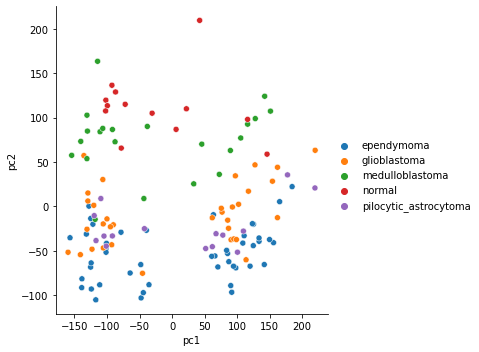

In [ ]:
df = df1
X = df.drop(columns=['samples', 'type']).to_numpy()
labels = df['type'].to_numpy()
scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)
pca = PCA(n_components=130)
principal_components = pca.fit_transform(Xscaled)
pltdf = pd.DataFrame({'label': labels, 'pc1': principal_components[:, 0], 'pc2' : principal_components[:, 1]})
sns.relplot(data=pltdf, x='pc1', y='pc2', hue=labels)

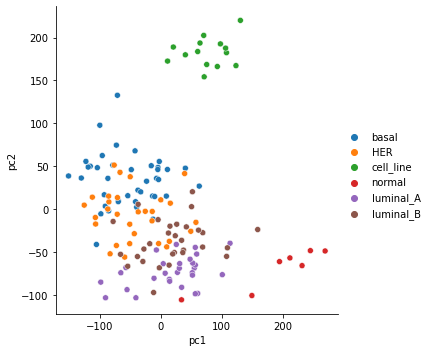

In [ ]:
df = df2
X = df.drop(columns=['samples', 'type']).to_numpy()
labels = df['type'].to_numpy()
scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)
pca = PCA(n_components=130)
principal_components = pca.fit_transform(Xscaled)
pltdf = pd.DataFrame({'label': labels, 'pc1': principal_components[:, 0], 'pc2' : principal_components[:, 1]})
sns.relplot(data=pltdf, x='pc1', y='pc2', hue=labels)

# Persistant homology

In [21]:
#create array of pointclouds based on neighbourhoods
df = df1
X = [None] * len(df)
r2 = 220
r1 = 150
for i in tqdm(range(len(df))):
    tempdf = df.drop(columns=['samples', 'type'])
    tempdf['dist'] = tempdf.apply(lambda x : np.linalg.norm(x - tempdf.iloc[i]), axis=1)
    X[i] = np.array(tempdf.loc[(tempdf['dist'] < r2) & (tempdf['dist'] > r1)])


100%|██████████| 130/130 [00:54<00:00,  2.36it/s]

In [45]:
#create array of point clouds based on sliding window

df = df1

def sliding_window(x, N):
    ret = np.zeros((int(len(x)/N),N))
    for i in range(int(len(x)/N)):
        ret[i] = x[i*N:(i+1)*N]
    return ret

N = 150

X = [None] * len(df)
for i in range(len(df)):
    x = df.drop(columns=['type', 'samples']).iloc[i].to_numpy()
    X[i] = sliding_window(x, N)

In [ ]:
H0['basal'][0].interleaving_distance(H0['basal'][1])

117.80210065175353

In [ ]:
H0.keys()

dict_keys(['basal', 'HER', 'normal', 'luminal_A', 'luminal_B', 'cell_line'])

In [41]:
#sample n elements from each type
n = 10
plotH0 = {}
plotH1 = {}
for type in H0.keys():
    plotH0[type] = np.random.choice(H0[type], n)
    plotH1[type] = np.random.choice(H1[type], n)

In [43]:
plotH0 = {}
plotH1 = {}
#take the average pcf of each type
for type in H0.keys():
    plotH0[type] = np.sum(H0[type]) / len(H0[type])
    plotH1[type] = np.sum(H1[type]) / len(H1[type])

In [42]:
plt.figure()
for type in plotH0.keys():
    for x in plotH0[type]:
        x.plot(label = type, color = cmap[type])
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [44]:
plt.figure()
for type in plotH0.keys():
    plotH0[type].plot(label = type, color = cmap[type])
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
plt.figure()
for type in H1.keys():
    H1[type].plot(color = colors[type], label = type)
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
plt.figure()
for type in H2.keys():
    H2[type].plot(color = colors[type], label = type)
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# KNN classifier based on persistent homology

In [30]:
dict = {}
dict.keys = np.unique(np.array(df['type']))

AttributeError: 'dict' object attribute 'keys' is read-only

In [276]:
from operator import itemgetter
class KNN():
    def __init__(self, k, r1, r2):
        self.k = k
        self.r1 = r1
        self.r2 = r2

    def train(self, X, y):
        self.X = X
        self.y = y
        self.H0 = []
        self.H1 = []
        Xpc = [None] * len(self.X)
        for i in tqdm(range(len(self.X))):
            temp = pd.DataFrame(data=self.X)
            temp['dist'] = temp.apply(lambda x : np.linalg.norm(x - temp.iloc[i]), axis=1)
            Xpc[i] = np.array(temp.loc[(temp['dist'] < self.r2) & (temp['dist'] > self.r1)])
            d = squareform(pdist(Xpc[i], 'euclidean'))
            c_dist = sr.Distance(d)
            f = c_dist.get_h0sr(clustering_method = "complete", reduced = False)
            bc = c_dist.get_bc(maxdim=1)
            g = sr.bc_to_sr(b, degree="H1")
            self.H0.append(f)
            self.H1.append(g)
        self.Xpc = Xpc
 
    def predict(self, x):
        temp = pd.DataFrame(data=self.X)
        temp['dist'] = temp.apply(lambda z : np.linalg.norm(z - x), axis=1)
        xpc = np.array(temp.loc[(temp['dist'] < self.r2) & (temp['dist'] > self.r1)])
        d = squareform(pdist(xpc, 'euclidean'))
        c_dist = sr.Distance(d)
        f = c_dist.get_h0sr(clustering_method = "complete", reduced = False)
        bc = c_dist.get_bc(maxdim=1)
        g = sr.bc_to_sr(b, degree="H1")
        distances = [(f.interleaving_distance(self.H0[i]) ** 2 +  g.interleaving_distance(self.H1[i]) ** 2)
                     for i in range(len(self.H0))]
        indices = sorted(range(len(distances)), key = lambda sub: distances[sub])[:self.k]
        preds = [self.y[i] for i in indices]
        return max(set(preds), key=preds.count)
        


In [202]:
y[55]

'glioblastoma'

In [207]:
np.unique(y)

array(['ependymoma', 'glioblastoma', 'medulloblastoma', 'normal',
       'pilocytic_astrocytoma'], dtype=object)

In [215]:
ytrain

array(['pilocytic_astrocytoma', 'medulloblastoma', 'glioblastoma',
       'ependymoma', 'medulloblastoma', 'normal', 'ependymoma', 'normal',
       'ependymoma', 'pilocytic_astrocytoma', 'medulloblastoma',
       'ependymoma', 'ependymoma', 'normal', 'ependymoma', 'ependymoma',
       'ependymoma', 'ependymoma', 'ependymoma', 'glioblastoma',
       'ependymoma', 'medulloblastoma', 'medulloblastoma', 'ependymoma',
       'medulloblastoma', 'medulloblastoma', 'ependymoma', 'ependymoma',
       'ependymoma', 'ependymoma', 'ependymoma', 'normal',
       'medulloblastoma', 'medulloblastoma', 'ependymoma', 'ependymoma',
       'normal', 'medulloblastoma', 'ependymoma', 'glioblastoma',
       'normal', 'glioblastoma', 'medulloblastoma',
       'pilocytic_astrocytoma', 'glioblastoma', 'glioblastoma',
       'glioblastoma', 'medulloblastoma', 'ependymoma', 'normal',
       'glioblastoma', 'glioblastoma', 'ependymoma', 'normal',
       'medulloblastoma', 'medulloblastoma', 'normal', 'glioblastom

In [248]:
plt.figure()
for i in range(len(model.H0)):
    if y[i] == "glioblastoma":
        model.H1[i].plot(color = 'red')
    elif y[i] == "ependymoma":
        model.H1[i].plot(color = 'green')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [273]:
correct = []
for i in range(len(Xtest)):
    correct.append(model.predict(Xtest[i]) == ytest[i])


In [275]:
sum(correct) / len(correct)

0.34782608695652173

In [272]:
from sklearn.model_selection import train_test_split
X = df2.drop(columns=["samples", "type"]).to_numpy()
y = df2["type"].to_numpy()
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.3) 
model = KNN(5,150,250)
model.train(Xtrain,ytrain)






  0%|          | 0/105 [00:00<?, ?it/s]



  1%|          | 1/105 [00:02<04:19,  2.50s/it]



  2%|▏         | 2/105 [00:04<04:03,  2.36s/it]



  3%|▎         | 3/105 [00:06<03:39,  2.16s/it]



  4%|▍         | 4/105 [00:08<03:38,  2.17s/it]



  5%|▍         | 5/105 [00:10<03:38,  2.19s/it]



  6%|▌         | 6/105 [00:12<03:29,  2.11s/it]



  7%|▋         | 7/105 [00:14<03:18,  2.03s/it]



  8%|▊         | 8/105 [00:17<03:40,  2.27s/it]



  9%|▊         | 9/105 [00:20<03:56,  2.46s/it]



 10%|▉         | 10/105 [00:21<03:33,  2.24s/it]



 10%|█         | 11/105 [00:23<03:23,  2.17s/it]



 11%|█▏        | 12/105 [00:26<03:34,  2.31s/it]



 12%|█▏        | 13/105 [00:26<02:41,  1.75s/it]



 13%|█▎        | 14/105 [00:29<02:56,  1.94s/it]



 14%|█▍        | 15/105 [00:30<02:39,  1.77s/it]



 15%|█▌        | 16/105 [00:33<02:50,  1.92s/it]



 16%|█▌        | 17/105 [00:35<02:57,  2.01s/it]



 17%|█▋        | 18/105 [00:38<03:17,  2.27s/it]



 18%|█▊        | 19/105 [0

In [258]:
plt.figure()
d = squareform(pdist(Xtrain, 'euclidean'))
plt.hist(d.flatten())

C:\Users\marve\AppData\Local\Temp/ipykernel_9204/1230677361.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([ 105.,    0.,    0.,   32.,  600., 3138., 3718., 1812., 1382.,
         238.]),
 array([  0.        ,  30.3207102 ,  60.64142041,  90.96213061,
        121.28284081, 151.60355102, 181.92426122, 212.24497142,
        242.56568163, 272.88639183, 303.20710203]),
 <BarContainer object of 10 artists>)